In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

####################################################################
## GeneNet Hyperparameters
B       = 32       #batch size
N       = 300       #timesteps
S       = 16         #number of species
dt      = 0.01      #time interval
L1      = 0.003      #L1 regularization parameter

## Genetic Algorithm Hyperparameters
POP_SIZE = 20               # population size
CLONES_NUM = 2               # Num of times of cloning, note: assert(POP_SIZE // CLONES_NO == 0)
CROSS_RATE = 0.8              # mating probability (DNA crossover) (1 here because there are duplicates anyway)
CROSS_POINT_RATE = 0.5     # DNA points crossover rate
REVERSE_CROSS_RATE = 0.5     # Reverse crossover printing rate
STEP_SIZE = 2               # mutation intensity
N_GENERATIONS = 100          # generation number
RAND_ITERATIONS = 1      # Initialization iterations
GA_ITERATIONS = 1         # GA iterations
PRUNE_ITERATIONS = 10     # Prune iterations
IWV = 5                  # Initial value of the initial_weights_data elements
#LOW_STEP_BOUND = 1 - STEP_SIZE
#HIGH_STEP_BOUND = 1 + STEP_SIZE

# Parameters (Derived from the hyperparameters, do not change anything)
DNA_SIZE = S*S              # DNA length
MUTATION_RATE = 0.5/DNA_SIZE        # mutation probability
if(POP_SIZE%CLONES_NUM == 0):
    SELECT_NUM = POP_SIZE//CLONES_NUM
else:
    raise AssertionError()

####################################################################
##Data 
input_      = tf.placeholder(tf.float32, shape=[N, B, S])
output_     = tf.placeholder(tf.float32, shape=[B])
initial_    = tf.placeholder(tf.float32, shape=[B, S])

####################################################################
##Variables to optimize
W = tf.Variable(tf.random_normal([S,S], mean = 0, stddev = 0.1, dtype = tf.float32))
A = tf.Variable(1.0, dtype = tf.float32)

####################################################################
##Nonlinearity chosen
def phi(x):
    return 1/(tf.exp(-x)+1)

####################################################################
##ODE function
def simulate(input_, initial_, W):
    output = tf.scan(lambda o,i: o + dt*(phi(tf.matmul(o,W))-o+i),
                            elems = input_,
                            initializer = initial_,
                            swap_memory = True)
    return output


output = simulate(input_, initial_, W)

####################################################################
## Training function
relevantOutput  = A*output[N-1,:,1]
fullOutput 		= A*output[N-1,:,:]

## Without regularization
cost = tf.reduce_mean(tf.square(((relevantOutput - output_)))) 
train_step = tf.train.AdamOptimizer(learning_rate=0.2, beta1=0.98, beta2=0.999, epsilon=1e-08).minimize(cost)
## With regularization
costL1 = tf.reduce_mean(tf.square(((relevantOutput - output_)))) + L1*tf.reduce_mean(tf.abs(W)) 
train_stepL1 = tf.train.AdamOptimizer(learning_rate=0.2, beta1=0.98, beta2=0.999, epsilon=1e-08).minimize(costL1)

####################################################################
## Initial Weights Data
initial_weights_data = []
# # 0: BI type French Flag
# initial_weights_data.append([[0, 0, 0],
#                             [0, IWV, -IWV],
#                             [-IWV, IWV, 0]])
# # 1: OD type French Flag
# initial_weights_data.append([[0, 0, -IWV],
#                             [IWV, 0, 0],
#                             [-IWV, IWV, 0]])
# # 2: IFF type French Flag
# initial_weights_data.append([[0, 0, 0],
#                             [IWV, 0, 0],
#                             [IWV, -IWV, IWV]])
# # 3: MI type French Flag
# initial_weights_data.append([[0, 0, 0],
#                             [IWV, 0, -IWV],
#                             [IWV, -IWV, 0]])
# # 4: FO type French Flag
# initial_weights_data.append([[IWV, 0, 0],
#                             [-IWV, 0, IWV],
#                             [-IWV, -IWV, IWV]])
# # 5: Classical French Flag
# initial_weights_data.append([[0, 0, 0],
#                             [-IWV, IWV, 0],
#                             [-IWV, -IWV, IWV]])

## Direct Method
# 0: BI type French Flag
initial_weights_data.append([[-4.62, -7.50, -7.77],
                            [-9.59, 16.07, -15.26],
                            [-18.12, 5.88, -5.99]])
# 1: OD type French Flag
initial_weights_data.append([[-43.88, -6.45, -16.36],
                            [46.57, 14.83, -11.99],
                            [-35.90, 1.80, -14.28]])
# 2: IFF type French Flag
initial_weights_data.append([[0.17, 4.85, -1.03],
                            [0.11, 0.13, -2.23],
                            [-0.06, -7.48, 4.28]])
# 3: MI type French Flag
initial_weights_data.append([[-1.28, -2.27, -5.70],
                            [-0.15, 8.92, 0.29],
                            [0.02, -5.45, 8.46]])
# 4: FO type French Flag
initial_weights_data.append([[-1.30, -2.19, -5.44],
                            [-0.59, 8.55, 0.52],
                            [-0.13, -5.41, 7.79]])
# 5: Classical French Flag
initial_weights_data.append([[-2.82079792, 0.7832284, -5.42571878],
                            [-0.22299732, -0.26842004, 0.46841779],
                            [-3.14926434, -5.17239904, 8.41496181]])

In [2]:
####################################################################
## Training data - here for a "stripe"
def newBatch(plot=False):
    initialVal      = 0.1*np.ones([B,S])
    if(plot):
        inputNoNoise = np.linspace(0,2,B)
    else:
        inputNoNoise    = np.random.uniform(0,2,B)
    inputVal        = inputNoNoise.reshape(B,1) * np.random.normal(loc=1.0, scale = 0.0001, size=[N,B,S])
    inputVal[:,:,1:S] = 0.0
    outputNoNoise   = np.zeros_like(inputNoNoise)
    #outputNoNoise[inputNoNoise > 1.0] = 1.0 # Original PlotAll
    outputNoNoise[np.logical_and(inputNoNoise > 0.5,inputNoNoise < 1.5 )] = 1.0
    return [inputVal, outputNoNoise, initialVal]

In [3]:
####################################################################
## Training model function
# Original GeneNet trainModel with tweaks
def trainModel(iterations,regularize=False,prune=False,pruneLimit=1,printing=False):
    mask = np.abs(sess.run(W)) > pruneLimit
    for i in range(iterations):
        [inputVal, outputVal, initialVal] = newBatch()
        if(regularize):
            sess.run(train_stepL1, feed_dict = {input_: inputVal, initial_: initialVal, output_: outputVal})
        else:
            sess.run(train_step, feed_dict = {input_: inputVal, initial_: initialVal, output_: outputVal})
        if(printing):
            ww = sess.run(cost, feed_dict = {input_: inputVal, initial_: initialVal, output_: outputVal})
            weights = sess.run(W)
            print([ww, i/iterations],end="\r")
        if(prune):
            applyMask = W.assign(W*mask)
            sess.run(applyMask)
            
    ww = sess.run(cost, feed_dict = {input_: inputVal, initial_: initialVal, output_: outputVal})
    outputW = sess.run(W)
    outputA = sess.run(A)
    return ww, outputW, outputA

In [4]:
# Original GeneNet randomized trainModel outputting weights and cost
def trainRandomModel(iterations,initial=-1,regularize=False,prune=False,pruneLimit=1,printing=False):
    # There is no failing mechanism if initial is less than -1 or more than 5
#     if(initial <= -1):
#         randomize_W = W.assign(tf.random_normal([S,S], mean = 0, stddev = 0.1, dtype = tf.float32))
#         sess.run(randomize_W)
#     elif(initial>=0 and initial<=5):
#         set_W = W.assign(initial_weights_data[initial])
#         sess.run(set_W)
#     else:
#         raise AssertionError()

    randomize_W = W.assign(tf.random_normal([S,S], mean = 0, stddev = 0.1, dtype = tf.float32))
    sess.run(randomize_W)
        
    randomize_A = A.assign(1.0)
    sess.run(randomize_A)
    
    mask = np.abs(sess.run(W)) > pruneLimit
    for i in range(iterations):
        [inputVal, outputVal, initialVal] = newBatch()
        if(regularize):
            sess.run(train_stepL1, feed_dict = {input_: inputVal, initial_: initialVal, output_: outputVal})
        else:
            sess.run(train_step, feed_dict = {input_: inputVal, initial_: initialVal, output_: outputVal})
        if(printing):
            ww = sess.run(cost, feed_dict = {input_: inputVal, initial_: initialVal, output_: outputVal})
            outputW = sess.run(W)
            print([ww, i/iterations],end="\r")
        if(prune):
            applyMask = W.assign(W*mask)
            sess.run(applyMask)
    
    ww = sess.run(cost, feed_dict = {input_: inputVal, initial_: initialVal, output_: outputVal})
    outputW = sess.run(W)
    outputA = sess.run(A)
    return ww, outputW, outputA

In [5]:
# Incomplete function. # TODO: Uses previously trained weights and cost to retrain them. 
def trainEvolvingModel(iterations, evolved_w, evolved_a, regularize=False,prune=False,pruneLimit=1,printing=False):
    set_W = W.assign(evolved_w)
    set_A = A.assign(evolved_a)
    sess.run(set_W)
    sess.run(set_A)
    mask = np.abs(sess.run(W)) > pruneLimit
    for i in range(iterations):
        [inputVal, outputVal, initialVal] = newBatch()
        if(regularize):
            sess.run(train_stepL1, feed_dict = {input_: inputVal, initial_: initialVal, output_: outputVal})
        else:
            sess.run(train_step, feed_dict = {input_: inputVal, initial_: initialVal, output_: outputVal})
        if(printing):
            ww = sess.run(cost, feed_dict = {input_: inputVal, initial_: initialVal, output_: outputVal})
            outputW = sess.run(W)
            print([ww, i/iterations],end="\r")
        if(prune):
            applyMask = W.assign(W*mask)
            sess.run(applyMask)
    
    ww = sess.run(cost, feed_dict = {input_: inputVal, initial_: initialVal, output_: outputVal})
    outputW = sess.run(W)
    outputA = sess.run(A)
    return ww, outputW, outputA

In [6]:
####################################################################
## Simulate model
def simulateModel():
    [inputVal, outputVal, initialVal] = newBatch(plot=True)
    finalOutput = sess.run(fullOutput, feed_dict = {input_: inputVal, initial_: initialVal, output_: outputVal})
    print(sess.run(W))
    print(sess.run(A))
    for j in np.arange(0,S):
        plt.plot(finalOutput[:,j])
    plt.show()

In [7]:
####################################################################
## GA Functions
# TODO: Upgrade the selection method to use rank method with diversity selector built in
def selection(w_storage, a_storage):    # selecting most fit half of population (no diversity built in)
    # Assuming children number is even
    # Assuming w_storage are sorted
    w_ret = []
    a_ret = []
    for i in range(SELECT_NUM):
        for _ in range(CLONES_NUM):
            w_ret.append(w_storage[i])
            a_ret.append(a_storage[i])
    return w_ret, a_ret

def crossover(population):     # mating process (genes crossover)
    for i in range(POP_SIZE):
        if np.random.rand() < CROSS_RATE:
        #if True: # Since there are duplicates, there's 20% chance it won't cross over anyway.
            crossover_target = np.random.randint(POP_SIZE)
            for j in range(DNA_SIZE):
                if np.random.rand() < CROSS_POINT_RATE:
                    if np.random.rand() < REVERSE_CROSS_RATE:
                        # printing from crossover_target WITH reverse printing (exchange)
                        reverse_tmp = population[i][j]
                        population[i][j] = population[crossover_target][j]
                        population[crossover_target][j] = reverse_tmp
                    else:
                        # no reverse printing
                        population[i][j] = population[crossover_target][j]
                    
            
    return population

#TODO: Should we mutate A?
def mutate(population):
    for i in range(POP_SIZE):
        for j in range(DNA_SIZE):
            #if np.random.rand() < MUTATION_RATE:
                # If STEP_SIZE is 1, it will only scales from 0~1
                # Default STEP_SIZE is 2, but should be increased according to type of problem
                # (-1)**np.random.randint(2) gives either -1 or 1
            population[i][j] += STEP_SIZE*np.random.rand() * (-1)**np.random.randint(2)
                # New mutation way:
                #population[i][j] *= STEP_SIZE * -1

    return population

In [8]:
# Roll & Unrolling
def unroll(_list):
    ret = []
    for i in range(S):
        for j in range(S):
            ret.append(_list[i][j])
            
    return ret

def roll(_list):
    ret = []
    _list.append(0) # delete if possible
    for i in range(S):
        ret.append(_list[i*S:i*S+3])

    return ret

In [9]:
#Triple mergesort sorting by alist
#TODO: convert cost_storage, w_storage, and a_storage into one single dictionary instead of three lists
def triple_mergesort(alist, blist, clist):
    #print("Splitting ",alist)
    if len(alist)>1:
        mid = len(alist)//2
        lefthalf_a = alist[:mid]
        lefthalf_b = blist[:mid]
        lefthalf_c = clist[:mid]
        righthalf_a = alist[mid:]
        righthalf_b = blist[mid:]
        righthalf_c = clist[mid:]
         

        triple_mergesort(lefthalf_a, lefthalf_b, lefthalf_b)
        triple_mergesort(righthalf_a, righthalf_b, righthalf_c)

        i=0
        j=0
        k=0
        while i < len(lefthalf_a) and j < len(righthalf_a):
            if lefthalf_a[i] < righthalf_a[j]:
                alist[k]=lefthalf_a[i]
                blist[k]=lefthalf_b[i]
                clist[k]=lefthalf_c[i]
                i=i+1
            else:
                alist[k]=righthalf_a[j]
                blist[k]=righthalf_b[j]
                clist[k]=righthalf_c[j]
                j=j+1
            k=k+1

        while i < len(lefthalf_a):
            alist[k]=lefthalf_a[i]
            blist[k]=lefthalf_b[i]
            clist[k]=lefthalf_c[i]
            i=i+1
            k=k+1

        while j < len(righthalf_a):
            alist[k]=righthalf_a[j]
            blist[k]=righthalf_b[j]
            clist[k]=righthalf_c[j]
            j=j+1
            k=k+1

In [10]:
####################################################################
## Determine type
# type_table = np.zeros(3**9)
# def update_type_table(trained_weights, type_table):
#     flat_w = []
#     for i in range(S):
#         for j in range(S):
#             flat_w.append(trained_weights[i][j])
#     for i in range(POP_SIZE):
#         index = 0
#         for j in range(DNA_SIZE):
#             if (flat_w[j] <= -1):
#                 index += 0
#             elif (flat_w[j] >= 1):
#                 index += 3**j
#             else:
#                 index += 2*(3**j)
#         # note: index's binaries are in reverse
#         type_table[index] += 1
        
#     return type_table;

## Determine not classical type straight away and stores the child number and generation
type_dict_table = {}
def determine_type(tw, type_dict_table):
    # tw means trained_weights
    return type_dict_table

In [11]:
####################################################################
## Train model (Original GeneNet)
#sess = tf.InteractiveSession()
#tf.global_variables_initializer().run()
#trainModel(iterations=10, printing=True)
#simulateModel()
#trainModel(iterations=1000, regularize=True)
#simulateModel()
#trainModel(iterations=1000, prune=True)
#simulateModel()


Randomly initialized Child # 0
[[-0.00741863  0.13044277 -0.2829209  -0.17580797 -0.32449043 -0.25566897
  -0.21638173  0.03398243  0.16226932  0.30525553 -0.10509817  0.24037418
  -0.13568139 -0.31241256 -0.0562215  -0.23643243]
 [-0.20241968  0.1451025  -0.47250551 -0.14019941 -0.24995974 -0.18879738
  -0.16495249  0.12997359  0.18392743  0.19928367  0.04524048  0.22192913
  -0.06436777 -0.1264033   0.30502081 -0.09070607]
 [-0.27001053  0.08898436 -0.32178408 -0.13351712 -0.1379914  -0.14483061
  -0.1086143   0.11130749  0.21134195  0.20278178 -0.09454604  0.20316406
  -0.25418395 -0.22661586  0.17268695 -0.23746882]
 [-0.28420576  0.19406052 -0.15193686 -0.18505584 -0.25468785 -0.16697693
  -0.08110578  0.19722156  0.15341282  0.13195616 -0.1726944   0.17675552
  -0.21830422 -0.11417529  0.2277928  -0.22012733]
 [-0.20182206  0.12276475 -0.07651787 -0.20214675 -0.09323531 -0.17562725
  -0.22112644  0.22386347  0.46074283  0.24134606  0.00074269  0.01615842
   0.02388807 -0.2575564

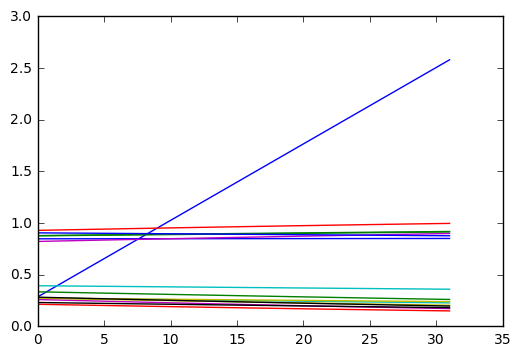

Cost: 0.389652
Time:  0.47795605659484863

Randomly initialized Child # 1
[[ -1.80989042e-01   1.39967740e-01  -8.28638859e-03  -3.15139502e-01
   -1.26801223e-01  -2.00951070e-01  -1.55474380e-01   7.95510635e-02
   -1.41703397e-01  -1.30065769e-01  -1.01661466e-01   1.69537395e-01
   -2.76557803e-01  -4.60793748e-02   1.44299015e-01  -3.03689353e-02]
 [ -2.32003808e-01   2.22595006e-01  -1.45309180e-01  -9.55544710e-02
   -3.10430080e-01  -1.51168212e-01  -6.40892908e-02  -1.81391239e-02
   -8.69335681e-02  -1.38776526e-01  -4.10002470e-03   3.10423821e-02
   -2.61025250e-01   2.13277876e-01   1.05207071e-01  -6.58581853e-02]
 [ -1.86228678e-01   2.84198135e-01   3.20139006e-02  -1.68141574e-01
   -1.00815885e-01  -8.50719064e-02  -2.84755379e-01  -1.41181946e-02
    4.42456454e-02  -5.69688082e-02  -2.10511208e-01   1.69812068e-01
    5.18701971e-03   1.53131008e-01   3.24799091e-01   5.69809601e-02]
 [ -3.72559667e-01   9.38304588e-02  -1.26945570e-01  -2.06084386e-01
   -1.9628644

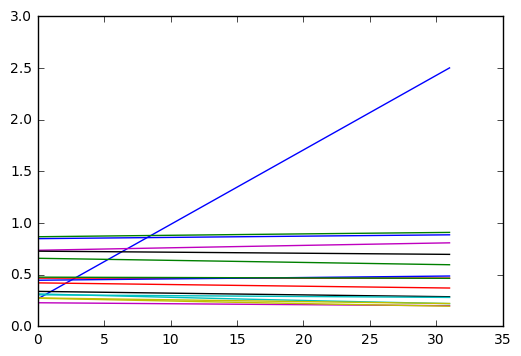

Cost: 0.354736
Time:  0.4314284324645996

Randomly initialized Child # 2
[[ -2.18501881e-01  -3.00794840e-03   6.87276796e-02  -2.36731291e-01
   -1.25974342e-01  -2.07017407e-01   6.91235289e-02  -9.59171802e-02
    5.74675202e-02  -1.99605912e-01  -1.06823780e-01  -6.49493933e-02
   -6.58200383e-02  -6.90597147e-02   1.85443252e-01  -1.02306813e-01]
 [ -1.75773785e-01   2.21760258e-01  -1.03977621e-01  -2.22647697e-01
    2.54789963e-02  -1.22049153e-01   6.40698299e-02  -2.12105229e-01
    6.35728836e-02  -2.74033099e-03  -1.30133525e-01  -1.00229420e-01
    4.99119163e-02  -2.49624569e-02   1.10856190e-01  -5.08320779e-02]
 [ -2.04015240e-01   1.89235657e-01   1.11997098e-01  -8.37518051e-02
   -1.34387732e-01  -1.63030013e-01  -9.80233327e-02  -1.12313747e-01
    1.55354306e-01  -1.49374694e-01  -3.01712066e-01  -1.51161909e-01
   -5.56087866e-03  -1.78919688e-01   2.43220516e-02  -3.46360058e-01]
 [ -1.42848313e-01   9.92245898e-02  -7.22571537e-02  -5.28124049e-02
   -4.52332422

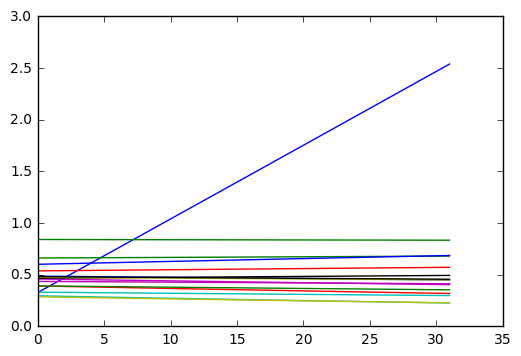

Cost: 0.342996
Time:  0.33786916732788086

Randomly initialized Child # 3
[[-0.06811087  0.26138777 -0.07589194 -0.16958195  0.08268531 -0.08448678
   0.01835724 -0.0176862  -0.101949   -0.18427473 -0.06392612  0.02533557
   0.04298881 -0.13160974 -0.17905904 -0.15530212]
 [ 0.06511051  0.2963818  -0.04129945 -0.1185457   0.04151871 -0.26340061
  -0.07048328 -0.03599685 -0.20840231 -0.12627153 -0.1059644  -0.2085287
  -0.05201636 -0.13578887  0.0774475  -0.15953216]
 [-0.21677703  0.09795827  0.03556373 -0.33548445  0.01362004 -0.12188365
  -0.15275532 -0.19566457  0.00151716 -0.13523474 -0.16361599 -0.07656733
  -0.03592127 -0.0897935   0.0395712  -0.22333455]
 [-0.10244205  0.15240824 -0.10426207 -0.03352097 -0.04394313 -0.36966538
   0.12676878 -0.14107175 -0.11758308 -0.11513332 -0.20841506 -0.22003782
  -0.01247478 -0.00357261  0.01786019  0.02639731]
 [-0.20719124  0.32202932 -0.11678445 -0.38436198  0.18923353 -0.29773536
   0.1405699  -0.0846065   0.03070907 -0.14134862 -0.0111

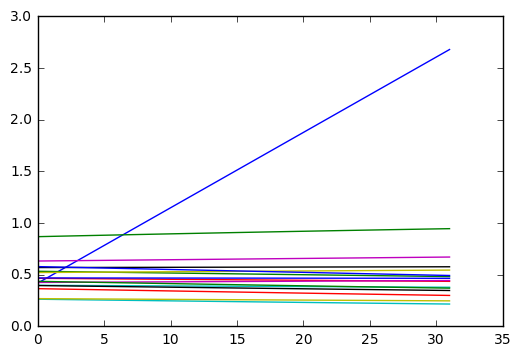

Cost: 0.343034
Time:  0.3704228401184082

Randomly initialized Child # 4
[[ -1.33021653e-01   2.43122220e-01  -4.71767895e-02  -1.12213403e-01
    1.53946161e-01   1.94940493e-02  -8.73267353e-02  -2.40526944e-02
   -1.81691825e-01  -2.74453640e-01  -1.40896678e-01   9.54270363e-05
    1.74569264e-01   8.46724361e-02  -3.39736789e-02  -2.63595760e-01]
 [ -2.32722521e-01   2.11544298e-02   4.10878807e-02  -1.00442559e-01
    1.13067150e-01   2.26177797e-02  -3.03653423e-02  -1.67491406e-01
    3.77680548e-02  -2.35266358e-01  -9.86734629e-02  -1.12645254e-01
   -4.52605337e-02  -2.05882639e-01   7.34320879e-02   1.00014798e-01]
 [ -7.20406398e-02   2.03428492e-02   9.95328277e-02  -2.29793936e-01
    2.19526619e-01  -2.29531862e-02   8.15914571e-02  -2.32982099e-01
    1.05352983e-01  -1.90106213e-01  -7.87159204e-02  -2.92173088e-01
    7.62001500e-02  -6.82774484e-02   2.06463993e-01  -1.93132967e-01]
 [ -2.76335657e-01   1.02701738e-01   1.20610729e-01  -2.71494806e-01
   -1.55082226

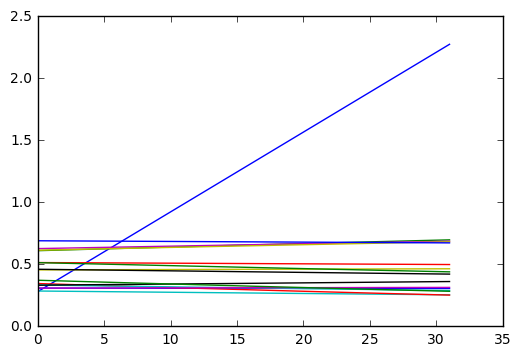

Cost: 0.334697
Time:  0.3477022647857666

Randomly initialized Child # 5
[[ -1.35980040e-01   1.24907121e-02   8.69069900e-03  -5.56422323e-02
    2.70135999e-01  -5.62320501e-02  -7.23713487e-02  -1.91647679e-01
   -7.06779584e-02   6.87355027e-02  -2.14396432e-01  -9.66459960e-02
    1.64339140e-01  -1.30845726e-01  -1.10983722e-01   2.07830369e-02]
 [ -1.75605118e-02  -3.65709513e-03   2.40082502e-01  -1.95812076e-01
    2.03521743e-01   6.30110651e-02  -8.24785605e-02  -1.34990409e-01
    3.37667018e-02  -1.68339565e-01   6.67700768e-02  -2.24757418e-02
   -5.82882389e-02  -1.98397607e-01   7.97313750e-02  -3.48117687e-02]
 [ -5.95813319e-02   5.22032268e-02  -1.74956933e-01  -1.85104296e-01
    4.74566445e-02   6.76563084e-02  -1.84448779e-01   7.59477019e-02
   -1.28358044e-03  -8.03147703e-02  -7.71088004e-02   2.14257091e-03
    2.47640200e-02  -1.87333286e-01   3.94584537e-02   1.56196073e-01]
 [ -9.48909074e-02   1.41459078e-01   4.36879396e-02  -2.65479892e-01
    2.94191986

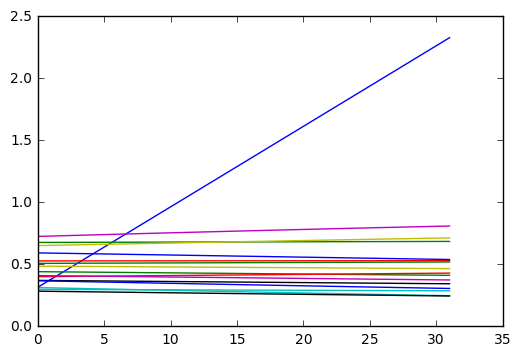

Cost: 0.260588
Time:  0.31546807289123535

Randomly initialized Child # 6
[[ -1.90890849e-01  -1.24766305e-02   1.63358264e-03  -1.57994717e-01
   -5.96198812e-02  -1.73178196e-01  -1.98874205e-01   5.56686521e-03
    1.61360562e-01   1.06089257e-01  -1.71419740e-01  -1.15310997e-02
    1.24199107e-01  -9.37103406e-02   1.66179910e-01  -1.11189872e-01]
 [  7.10587054e-02   2.02390417e-01  -8.99572521e-02  -1.39985397e-01
   -9.08202752e-02  -5.95283471e-02   1.07156724e-01  -2.58368477e-02
    3.33558843e-02  -2.46157572e-01  -1.50569707e-01  -1.35657653e-01
    2.55364001e-01  -3.12120497e-01  -1.20073721e-01  -1.11829400e-01]
 [ -1.35768950e-01   9.20242891e-02  -3.11525371e-02  -2.62109578e-01
   -7.25487769e-02   9.85195935e-02   2.71162763e-02  -1.06179714e-01
   -2.77056228e-02  -7.78059661e-02  -2.59906054e-04   3.47993001e-02
    1.05502427e-01  -3.59893963e-02   1.58284843e-01   4.85454649e-02]
 [  3.16288099e-02   1.16299421e-01   1.38434887e-01  -1.51833937e-01
    2.0994458

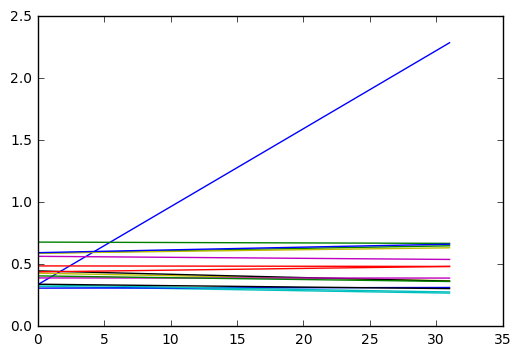

Cost: 0.291269
Time:  0.323258638381958

Randomly initialized Child # 7
[[-0.01239881  0.11504142 -0.05320141 -0.00428395  0.12850258  0.05031767
  -0.14341912  0.08829357  0.06012589 -0.00952514 -0.0243021  -0.07196321
   0.00988682 -0.01462664  0.03703137 -0.04790531]
 [ 0.05389215  0.00201928 -0.14787078 -0.19940746 -0.0362971  -0.07598134
  -0.09568402 -0.30113307  0.01351579 -0.15068579 -0.13117346  0.15697993
   0.07989037 -0.09992856 -0.01429545 -0.07688256]
 [-0.15137595  0.02636602  0.18365885  0.03369924  0.35961667 -0.00208607
  -0.04887806 -0.09086806 -0.00762184 -0.00834202 -0.17713074 -0.33129084
  -0.06998459  0.06966177  0.08381087  0.01473345]
 [-0.09655595  0.10521676  0.04619271 -0.18045831  0.09823658 -0.12781739
  -0.12345841 -0.23423812 -0.02415492 -0.13798173 -0.07955109 -0.36310077
  -0.07886819 -0.10034028  0.12793408  0.15684202]
 [-0.15646422  0.08537706 -0.19148883 -0.0496535  -0.04578615 -0.12950264
  -0.01037272 -0.05392471  0.00786371 -0.19184303 -0.13238

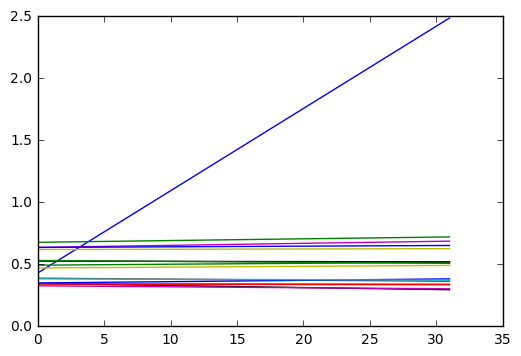

Cost: 0.228463
Time:  0.3356015682220459

Randomly initialized Child # 8
[[-0.21325567  0.05989574 -0.00501195 -0.16115209  0.15393248 -0.05667231
  -0.14700021 -0.06042513  0.11657652 -0.16791964 -0.18575968 -0.22964805
   0.14349255 -0.00100559  0.06550651  0.14990039]
 [ 0.02841002  0.15482186  0.05040271 -0.13069037  0.11185679  0.14314047
  -0.10337406 -0.0172102   0.12159505 -0.05300729 -0.07998701 -0.14565769
   0.0214588  -0.08571628  0.02188394 -0.06159262]
 [ 0.21508566  0.07076026  0.11631319 -0.07098243  0.21203491  0.03017787
  -0.37288651 -0.05432     0.00977602  0.01693246 -0.12662268 -0.07185298
   0.02449654  0.02791986  0.1091074  -0.05228708]
 [-0.1606213   0.27696034 -0.10745622  0.01890459  0.1061251  -0.12473544
  -0.01906179 -0.08625299 -0.06895196 -0.03796837 -0.11501805  0.02719255
   0.13410331 -0.00140573  0.20667762 -0.13925567]
 [ 0.02183001  0.34115198 -0.1630626  -0.02999314  0.0704312  -0.24112475
  -0.11220184  0.00629823 -0.06255443 -0.0629392   0.1114

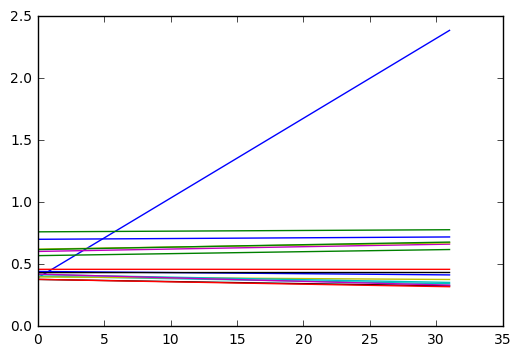

Cost: 0.257223
Time:  0.3710346221923828

Randomly initialized Child # 9
[[-0.22924292 -0.0071931  -0.20965825 -0.07213369  0.09817908 -0.20326787
  -0.10223551 -0.08466247 -0.06307141 -0.01711253 -0.10991376 -0.01009351
   0.04788995 -0.20521039 -0.024099   -0.00883384]
 [-0.28627241  0.02594054 -0.11935872  0.04449777  0.09114791  0.01754541
  -0.06914807 -0.02194623  0.01290072 -0.19794673 -0.00994659 -0.11841209
  -0.11890697  0.17451632  0.0220497   0.02633082]
 [-0.0868805   0.08726121 -0.13185911 -0.07448171  0.28206533 -0.01475627
  -0.08900185 -0.01239708  0.20036379 -0.14337829 -0.28079176 -0.09087647
   0.00171682 -0.12348589  0.23522933  0.00310065]
 [-0.02796494 -0.03397986 -0.10786764 -0.12159887  0.17481314 -0.04447041
  -0.21193434  0.1342327   0.11415856 -0.25167128 -0.00150808 -0.04785692
   0.07074001 -0.13240881  0.17394742 -0.06182288]
 [-0.0760938   0.02938879 -0.21745567 -0.10688931 -0.01414108  0.00045741
  -0.09646212  0.02537286  0.11422172 -0.2280516  -0.2895

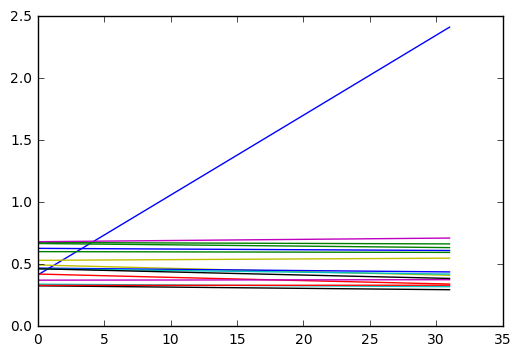

Cost: 0.268993
Time:  0.36461734771728516

Randomly initialized Child # 10
[[-0.03401966 -0.00669778 -0.08685762 -0.1330777  -0.13776857 -0.08194977
   0.1257589  -0.04134302  0.11172275 -0.1492722   0.06570298 -0.19032818
  -0.03548704 -0.01864629  0.01937464  0.06090651]
 [-0.09712049  0.14431734  0.00740211 -0.12188825  0.01174569 -0.06168545
   0.14673261  0.08581129  0.01625723  0.08373607 -0.07734704 -0.06488968
  -0.09195942  0.01843981 -0.03422252  0.03329684]
 [-0.17193851  0.27032143  0.02912508 -0.13241729  0.04223812 -0.32721925
   0.0613613  -0.1297386   0.06542346  0.0180219   0.01551417  0.04378723
  -0.06422964 -0.16662647  0.07687796  0.23402306]
 [-0.1278058  -0.03468547 -0.03473344 -0.02369161 -0.00611999 -0.01263224
  -0.16647977 -0.10559405  0.10314855 -0.21332109  0.05837348 -0.13490461
  -0.07913981  0.04377047 -0.08879513 -0.01738374]
 [-0.07907797  0.12581615 -0.07779656  0.16283427  0.04657974 -0.07985414
   0.07223482 -0.0017948   0.13165954 -0.10303174 -0.30

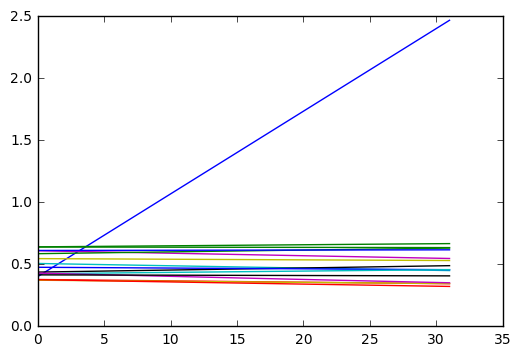

Cost: 0.29483
Time:  0.4638631343841553

Randomly initialized Child # 11
[[-0.11139574  0.11004882 -0.05128704  0.05387243  0.052847   -0.0632443
   0.0063055  -0.07104065  0.26203081 -0.01827244 -0.19771776  0.06770466
  -0.06713802  0.01520815 -0.05508024  0.00665432]
 [-0.01698717  0.30724776  0.03740803 -0.11136147 -0.00188963 -0.02211777
  -0.01758157  0.01647015  0.14581305  0.0365494  -0.10587913 -0.09568129
  -0.00218337 -0.02452493 -0.06447807  0.01107821]
 [-0.10139421  0.09762536 -0.04018682  0.03342214  0.24330981 -0.04037562
   0.03536005  0.03336846  0.14754876 -0.14958075  0.04577848 -0.05262159
   0.13561299 -0.15090023 -0.02479608 -0.2093046 ]
 [-0.15877303  0.07795334 -0.07172499  0.01026643  0.03596819 -0.21827194
  -0.00221254 -0.12300684  0.11656611 -0.28558487 -0.10377879 -0.20206879
   0.27861628 -0.17554057  0.0349133  -0.11130536]
 [-0.11173981  0.07786156  0.03543494 -0.11617836 -0.03879532 -0.18196487
  -0.02132347 -0.08312169  0.16117714 -0.19298047 -0.13818

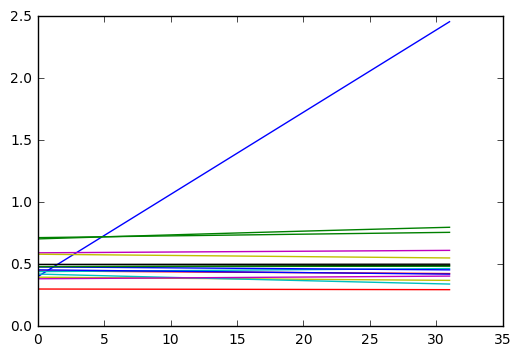

Cost: 0.231508
Time:  0.3280608654022217

Randomly initialized Child # 12
[[  8.04157257e-02  -2.84091905e-02  -1.82347298e-02  -2.09318087e-01
   -2.11937055e-02  -7.10602105e-02   9.22445878e-02  -1.96087360e-02
    1.16390608e-01  -2.29389936e-01  -1.25534832e-01   5.36127090e-02
    1.31847471e-01   2.00592190e-01  -5.29095531e-02   5.18886335e-02]
 [ -8.13583583e-02   4.71793786e-02   1.43071741e-01  -2.23403871e-01
    1.04569949e-01  -3.44998837e-02   8.12168047e-02   1.20536424e-01
   -4.94468212e-02  -3.06081325e-01   1.48397207e-01  -2.72801854e-02
    1.81577168e-02   2.93746978e-01   3.98063213e-02   6.91141486e-02]
 [ -2.83843353e-02   2.39548951e-01  -2.56210100e-02  -1.22425005e-01
    3.55320051e-02   1.26568824e-02   1.01717010e-01  -8.79301876e-03
    4.94994074e-02  -1.24219835e-01   5.91869280e-02   2.06816792e-02
    1.10243961e-01   1.23975947e-01  -2.19395235e-01  -2.85064541e-02]
 [ -1.25669390e-02   5.28103188e-02   3.96771729e-02  -9.17899311e-02
    8.7779879

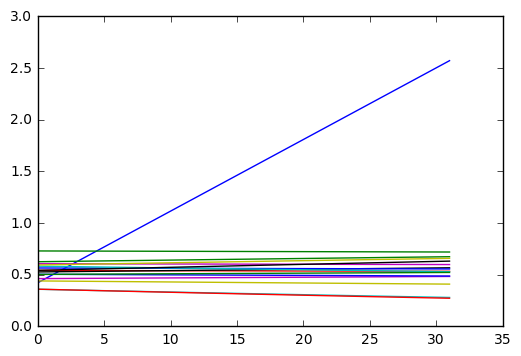

Cost: 0.285624
Time:  0.32657623291015625

Randomly initialized Child # 13
[[ -1.03538975e-01   2.07472995e-01  -1.42468438e-01  -1.46046579e-02
    2.72984058e-02  -1.56578064e-01  -1.18433051e-02  -4.72882539e-02
   -1.46812499e-02  -9.91913676e-02  -2.45214403e-02   2.85900906e-02
   -8.20690244e-02  -1.30458977e-02  -2.09190324e-01   5.19194640e-04]
 [ -2.46951014e-01  -5.21290749e-02   3.01681068e-02  -1.41250193e-01
   -2.64121145e-02  -9.61098596e-02   7.29802549e-02  -1.16481647e-01
    1.49384841e-01  -1.45844877e-01  -2.16068421e-02  -7.91541487e-02
    2.19657689e-01  -2.44889408e-02  -3.16420682e-02  -6.64961338e-02]
 [  1.15413360e-01   2.21665278e-02  -7.94656128e-02  -7.22570270e-02
    7.52622262e-02  -5.51672913e-02  -8.98874272e-03  -1.31838232e-01
    8.13177899e-02  -2.25221530e-01  -6.80307820e-02  -2.91647315e-01
    2.59674303e-02   9.53969806e-02   8.75595808e-02  -5.68001717e-03]
 [ -2.10960209e-02  -3.62337381e-03   4.60106730e-02  -2.01493353e-01
   -4.573691

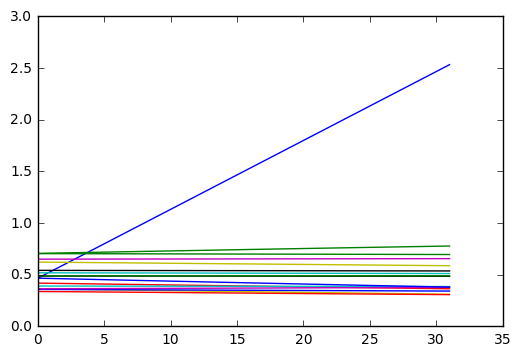

Cost: 0.298714
Time:  0.3332517147064209

Randomly initialized Child # 14
[[ -2.56085336e-01   9.21775103e-02   1.23855881e-02  -1.50832504e-01
   -1.98345631e-03  -8.80010948e-02   2.49090865e-02  -1.63813889e-01
    1.71733439e-01   1.04025677e-02   2.56120246e-02  -9.02092308e-02
    4.06567231e-02  -6.90555945e-02   5.21469787e-02   3.48545127e-02]
 [ -1.11271992e-01  -5.01740426e-02   2.00040620e-02   1.81406587e-01
    1.37987033e-01   8.94891173e-02   4.01108107e-03   3.98460776e-03
    2.55173266e-01   1.98747516e-01   7.54182488e-02  -6.42503053e-02
    3.03424969e-02   1.24114566e-01  -4.29500267e-02   1.50240585e-01]
 [ -1.11179933e-01  -2.26617455e-02  -1.88948140e-01   3.54607329e-02
    1.83376208e-01  -1.76601335e-02  -4.44703400e-02  -1.27776191e-01
    3.32976617e-02  -1.16244443e-01  -1.13059245e-01  -1.49087876e-01
   -9.20061022e-02   3.65306139e-02   4.49858606e-04   2.63079535e-02]
 [ -1.04772106e-01   2.05156580e-02   6.71944991e-02  -9.42589268e-02
    2.6639357

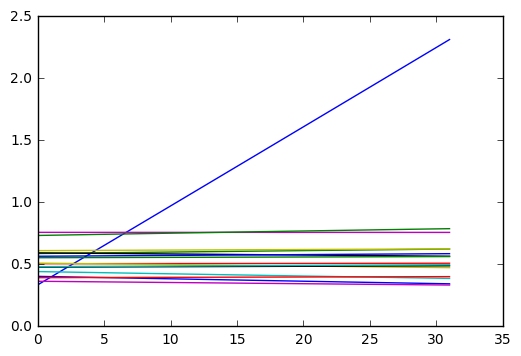

Cost: 0.314119
Time:  0.32724452018737793

Randomly initialized Child # 15
[[-0.15024781  0.37666184 -0.03196996 -0.1197623  -0.10161772  0.00065496
  -0.07957289 -0.04685475  0.07449826 -0.14706655  0.00939437 -0.06457474
   0.10589286 -0.06407887 -0.01370373 -0.03275961]
 [-0.06813765  0.11809842 -0.10334162  0.13088545 -0.01893476  0.00135237
  -0.05333954 -0.01647894  0.08730539 -0.05929624 -0.00428274 -0.14271791
  -0.04582823  0.07941326 -0.03216953  0.08181798]
 [-0.16805094 -0.095592    0.084241   -0.25149888  0.08920085 -0.12898043
   0.02218654 -0.1030786  -0.06985615 -0.0747008  -0.01201182 -0.03067686
   0.03402941  0.04907725 -0.05716933  0.03010252]
 [-0.14814584  0.0536367   0.10166536 -0.03491182 -0.01420519 -0.18993837
  -0.10060219  0.05146804  0.19718599 -0.05839467 -0.00441155 -0.04297441
  -0.09345233 -0.0273136   0.04319623  0.09913487]
 [-0.04032193  0.24542597 -0.05056611 -0.05295471 -0.09680309  0.03308284
  -0.12621996  0.02953817  0.16669604 -0.03210787 -0.08

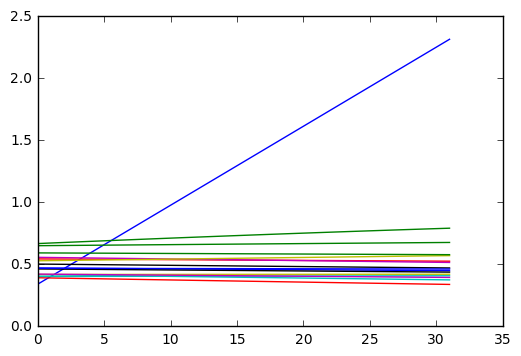

Cost: 0.308529
Time:  0.3513987064361572

Randomly initialized Child # 16
[[-0.04611946  0.03246817  0.03051081 -0.12412886  0.19125235  0.06087271
   0.11072707 -0.03313155  0.06362434  0.03814916 -0.06809562 -0.09488009
   0.11370777  0.0935166  -0.10956358  0.07245288]
 [ 0.05406494 -0.0012015  -0.07985928 -0.06906374  0.00889115 -0.01610459
   0.08635317  0.15943572  0.10602634 -0.09887904 -0.10074866 -0.06988754
   0.06439726  0.00844597  0.02415701  0.02667008]
 [-0.06114753 -0.19171776  0.03469139 -0.00775215  0.03487904 -0.08984095
  -0.08490062 -0.14356293  0.12908632 -0.11270678 -0.00788871  0.0190865
   0.10315658  0.14261082 -0.09565712  0.03387967]
 [ 0.0192799   0.05372102  0.06133884 -0.12137234 -0.06173138 -0.12276579
   0.09879155 -0.12156491  0.1340932   0.0836847  -0.07057203 -0.08168463
   0.02281389 -0.09238753  0.12869436 -0.00747329]
 [-0.17615092  0.10807291  0.04276081  0.15604304 -0.02538361 -0.09705344
   0.2003018   0.04213553 -0.05620545 -0.14804178  0.1182

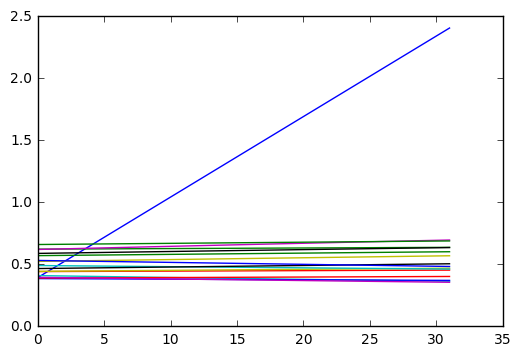

Cost: 0.25905
Time:  0.3683288097381592

Randomly initialized Child # 17
[[-0.08162378  0.09086579 -0.03361243  0.08136219  0.04456112 -0.00150071
  -0.06259936 -0.073138    0.1543299  -0.11609165 -0.02093994  0.06752183
  -0.07857599 -0.05041755 -0.00721661  0.12786026]
 [-0.24381834  0.020875   -0.01534645 -0.2441172  -0.12179647 -0.0340223
  -0.00411639 -0.02518473  0.07869651  0.02216364  0.2099368  -0.1934551
  -0.15854967 -0.19010645  0.0625286   0.04830921]
 [-0.17658655  0.11542407 -0.02059456 -0.04489158  0.12655181  0.13247152
  -0.06976739 -0.09624736 -0.1523013  -0.09882297 -0.07437991  0.08996186
   0.10858814 -0.19711398  0.19432393 -0.00733891]
 [-0.01700976  0.21943089  0.04950605  0.32351726  0.1014598   0.07628565
   0.06274045 -0.18872626  0.04850859 -0.08947469 -0.07267258 -0.1596211
   0.03709643 -0.10834084  0.0610261   0.08872955]
 [-0.2129105   0.2166751   0.1075625  -0.24772158  0.12204397  0.08997714
   0.05062817 -0.09922099  0.07538235 -0.08547749 -0.0051773

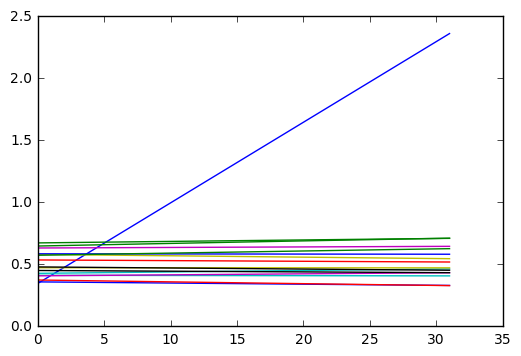

Cost: 0.248533
Time:  0.3371126651763916

Randomly initialized Child # 18
[[ -4.24273312e-02   3.71197239e-02  -1.52415633e-02  -1.70593768e-01
    1.41348332e-01  -1.65365756e-01  -6.12164102e-03   1.19306706e-02
    9.39309597e-02  -1.02101155e-01  -4.12020087e-03   6.77672327e-02
   -9.36104879e-02   6.70714378e-02  -8.50524902e-02   8.28316957e-02]
 [ -8.17167908e-02  -4.37274575e-05  -7.45087340e-02   8.56857970e-02
    6.53329045e-02   4.99828309e-02   4.39473875e-02  -3.91250737e-02
    8.06577504e-03  -1.93775669e-01  -2.36270055e-02   1.00056008e-01
    8.95676613e-02  -1.05434164e-01  -1.22609124e-01  -1.49949312e-01]
 [ -1.27441406e-01   8.55597705e-02   4.97897379e-02   8.25686827e-02
    1.32027596e-01   3.47251520e-02  -7.93390796e-02  -1.61356032e-01
    8.08636844e-03  -1.89278692e-01  -7.07597584e-02  -2.31856704e-01
    1.16991125e-01  -1.38270736e-01  -5.21942675e-02   6.53390735e-02]
 [ -7.55623057e-02   2.03328088e-01   8.26385617e-02  -2.60628723e-02
    3.4818878

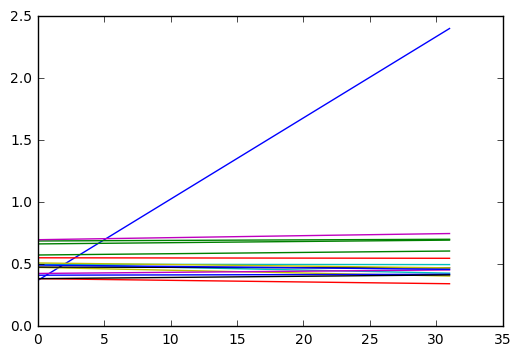

Cost: 0.275432
Time:  0.3313159942626953

Randomly initialized Child # 19
[[ -1.39606535e-01   1.32641330e-01   2.54485235e-02   1.58312321e-01
    2.64803730e-02   1.03014663e-01  -4.74051200e-02  -1.20643087e-01
    1.28160030e-01  -1.19470492e-01  -4.80960384e-02  -7.72268176e-02
   -1.99747801e-01  -1.98077112e-02  -1.36853740e-01  -6.84812292e-02]
 [ -1.12153888e-02   8.27136263e-02  -9.13065821e-02  -5.34415618e-03
    9.77876559e-02  -1.37645096e-01  -4.40552384e-02  -1.38009980e-01
    1.33643150e-01  -5.92610464e-02  -1.56798974e-01  -1.95410788e-01
   -2.94128507e-02  -1.14657179e-01  -2.17515901e-02  -3.91933024e-02]
 [ -1.90021247e-02   2.51589656e-01   7.78845511e-03   7.41141438e-02
    1.29245222e-02  -9.36300382e-02   9.97094363e-02  -9.29817408e-02
   -7.38490596e-02  -1.34257108e-01   1.31244302e-01  -2.53305316e-01
   -1.25674158e-01   7.53369257e-02  -1.33323714e-01  -5.11433333e-02]
 [ -1.47960261e-01   9.05883983e-02   3.10106389e-02  -1.16544075e-01
    8.1227473

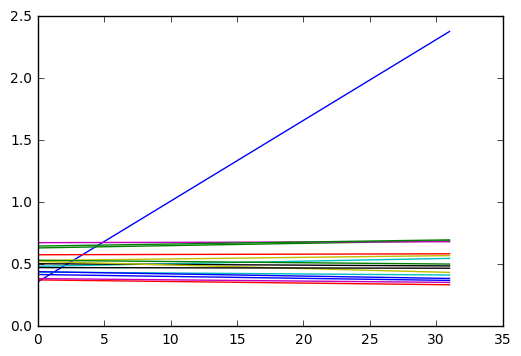

Cost: 0.237848
Time:  0.45775270462036133


In [11]:
####################################################################
## GA-Layered Train model
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

##Global Storage
# Note that the weights are not converted to anything else from real form.
cost_storage = []     # Cost lookup table
w_storage = [];       # Stores children weights
a_storage = [];       # Stores A


# Initialize random children and stores them to weights_storage
# Assume POP_SIZE is 12
for p in range(POP_SIZE):
    t1 = time.time()
    print("\nRandomly initialized Child #",p)
    child_cost, child_w, child_a = trainRandomModel(iterations=RAND_ITERATIONS, initial=-1)
    #simulateModel()
    #print("After regularize...")
    #child_cost, child_w, child_a = trainModel(iterations=PRUNE_ITERATIONS, regularize=True)
    #simulateModel()
    #print("After pruning...")
    #child_cost, child_w, child_a = trainModel(iterations=PRUNE_ITERATIONS, prune=True)
    simulateModel()
    print("Cost:", child_cost)
    cost_storage.append(child_cost)
    w_storage.append(child_w)
    a_storage.append(child_a)
    t2 = time.time()
    print("Time: ", t2-t1)

#print(cost_storage)
#print(w_storage)
#print(a_storage)

In [12]:
for g in range(N_GENERATIONS):
    print("\n --- STARTING NEW GENERATION", g, "... ---")
    triple_mergesort(cost_storage, w_storage, a_storage)
    #print(cost_storage)
    #print(w_storage)
    #print(a_storage)
    
    print("cost_storage overview: ", cost_storage)
    
    # loop
    selected_w, a_storage = selection(w_storage, a_storage) # Only selects best half and duplicate them
    #print(selected_w)
    #print(selected_a)
    
    # unrolling
    unrolled_w = []
    for i in range(POP_SIZE):
        unrolled_w.append(unroll(selected_w[i]))
    #print(unrolled_w)

    #unrolled_w = crossover(unrolled_w)
    #print(unrolled_w)
    unrolled_w = mutate(unrolled_w)
    #print(unrolled_w)

    # rolling
    w_storage = []
    for i in range(POP_SIZE):
        w_storage.append(roll(unrolled_w[i]))
    #print(w_storage)

    for i in range(POP_SIZE):
        #TODO: Adds a normal trainModel without needing to pass the argument
        t1 = time.time()
        print("\nGeneration #", g)
        print("Child #", i)
        cost_storage[i], w_storage[i], a_storage[i] = trainEvolvingModel(iterations=GA_ITERATIONS,
                                                                         evolved_w=w_storage[i],
                                                                         evolved_a=a_storage[i],
                                                                         regularize=True)
        #simulateModel()
        #print("After regularization...")
        #cost_storage[i], w_storage[i], a_storage[i] = trainModel(iterations=PRUNE_ITERATIONS, regularize=True)
        #simulateModel()
        #print("After pruning...")
        #cost_storage[i], w_storage[i], a_storage[i] = trainModel(iterations=PRUNE_ITERATIONS, prune=True)
        simulateModel()
        print("Cost:", cost_storage[i])
        t2 = time.time()
        print("Time: ", t2-t1)
        
        # determine type
        #if(cost_storage[i] < 0.04):
        #    type_table = update_type_table(w_storage[i], type_table)
        
        #if(g%3 == 0):
        #    print(type_table, file=open("type_table.txt", "w"))
        
# TODO: Adds a final pruning generations
# TODO: After N_GENERATIONS, do something like printing them, or automatic type detection and extraction


 --- STARTING NEW GENERATION 0 ... ---
cost_storage overview:  [0.22846323, 0.23150772, 0.23784824, 0.24853349, 0.25722289, 0.25905037, 0.26058766, 0.26899284, 0.27543187, 0.28562397, 0.29126894, 0.29482973, 0.29871365, 0.30852872, 0.31411877, 0.33469748, 0.34299633, 0.34303442, 0.35473582, 0.38965166]

Generation # 0
Child # 0


ValueError: Dimension 1 in both shapes must be equal, but are 16 and 3 for 'Assign_40' (op: 'Assign') with input shapes: [16,16], [16,3].